
# Geographically Weighted Regression (GWR)

## Pendahuluan Geographically Weighted Regression (GWR)

*Geographically Weighted Regression* (GWR) adalah teknik statistik spasial yang mengembangkan analisis regresi tradisional dengan memungkinkan parameter lokal untuk diestimasi, bukan hanya mengasumsikan bahwa satu set parameter global dapat menjelaskan hubungan antar variabel di seluruh wilayah studi.

GWR menyadari bahwa hubungan spasial dapat bervariasi di seluruh ruang geografis, sehingga dapat mengatasi permasalahan *spatial non-stationarity* (ketidakstasioneran spasial).

### Konsep Utama

- **Regresi lokal**: Parameter diestimasi untuk setiap lokasi dalam wilayah studi.  
- **Bobot spasial**: Observasi yang lebih dekat dengan titik regresi memiliki pengaruh yang lebih besar.  
- **Pemilihan bandwidth**: Menentukan sejauh mana pengaruh spasial dalam model.  
- **Fungsi kernel**: Mendefinisikan bagaimana bobot menurun seiring dengan jarak.  

## Kerangka Matematis
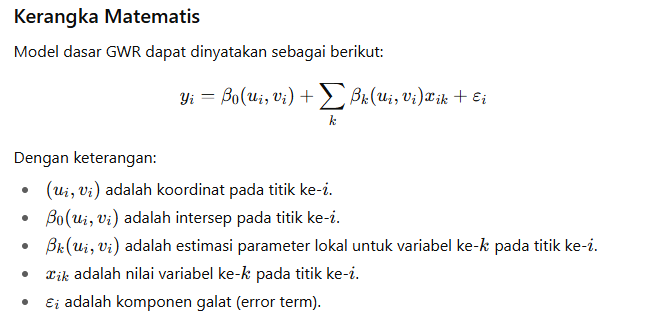

In [1]:
# ==============================
# Instalasi paket yang dibutuhkan
# ==============================
#!pip install esda spreg mgwr folium geopandas geopy seaborn
#!pip install mgwr

# ==============================
# Analisis spasial
# ==============================
import geopandas as gpd
from shapely.geometry import Point
import libpysal as ps
from esda import Moran
from spreg import OLS
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

# ==============================
# Data wrangling
# ==============================
import pandas as pd
import numpy as np

# ==============================
# Statistik & regresi
# ==============================
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ==============================
# Visualisasi
# ==============================
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
import seaborn as sns
from geopy.distance import geodesic

# ==============================
# Pemetaan interaktif
# ==============================
import folium

# ==============================
# Utilities tambahan
# ==============================
import requests
import zipfile
import io


# Memuat Data

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# baca file excel yang sudah diupload
df = pd.read_excel("../data/Data_Olah_Spasial.xlsx")

# ambil kolom yang dibutuhkan
df = df[["Tahun", "Kabupaten/Kota", "LAT", "LONG", "Y", "X1", "X2", "X3", "X4", "X5L"]]
df = df[df["Tahun"] == 2024]

# konversi ke GeoDataFrame
geometry = [Point(xy) for xy in zip(df["LONG"], df["LAT"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

gdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 119 entries, 0 to 118
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Tahun           119 non-null    int64   
 1   Kabupaten/Kota  119 non-null    object  
 2   LAT             119 non-null    float64 
 3   LONG            119 non-null    float64 
 4   Y               119 non-null    float64 
 5   X1              119 non-null    float64 
 6   X2              119 non-null    int64   
 7   X3              119 non-null    float64 
 8   X4              119 non-null    float64 
 9   X5L             119 non-null    float64 
 10  geometry        119 non-null    geometry
dtypes: float64(7), geometry(1), int64(2), object(1)
memory usage: 11.2+ KB


# Memuat Shapefile Indonesia

In [3]:
import geopandas as gpd
import requests, zipfile, io

# 1. Download file ZIP shapefile GADM Indonesia
#url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_IDN_shp.zip"
#r = requests.get(url)

# 2. Ekstrak ke memori
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall("gadm_idn")   # folder lokal "gadm_idn"

# 3. Baca shapefile level 2 (kabupaten/kota)
indo = gpd.read_file("gadm_idn/gadm41_IDN_2.shp")

print(indo.head())


       GID_2 GID_0    COUNTRY    GID_1 NAME_1 NL_NAME_1           NAME_2  \
0  IDN.1.2_1   IDN  Indonesia  IDN.1_1   Aceh        NA       Aceh Barat   
1  IDN.1.1_1   IDN  Indonesia  IDN.1_1   Aceh        NA  Aceh Barat Daya   
2  IDN.1.3_1   IDN  Indonesia  IDN.1_1   Aceh        NA       Aceh Besar   
3  IDN.1.4_1   IDN  Indonesia  IDN.1_1   Aceh        NA        Aceh Jaya   
4  IDN.1.5_1   IDN  Indonesia  IDN.1_1   Aceh        NA     Aceh Selatan   

  VARNAME_2 NL_NAME_2     TYPE_2 ENGTYPE_2  CC_2    HASC_2  \
0        NA        NA  Kabupaten   Regency  1107  ID.AC.AB   
1        NA        NA  Kabupaten   Regency  1112  ID.AC.AD   
2        NA        NA  Kabupaten   Regency  1108  ID.AC.AR   
3        NA        NA  Kabupaten   Regency  1116  ID.AC.AJ   
4        NA        NA  Kabupaten   Regency  1103  ID.AC.AS   

                                            geometry  
0  POLYGON ((96.06915 4.19539, 96.06725 4.19651, ...  
1  MULTIPOLYGON (((96.94196 3.57464, 96.9411 3.57...  
2  MU

In [4]:
# Filter hanya provinsi di Pulau Jawa
jawa_prov = ["Jakarta Raya", "Banten", "Jawa Barat", "Jawa Tengah", "Yogyakarta", "Jawa Timur"]
jawa = indo[indo["NAME_1"].isin(jawa_prov)]

# Cek kolom nama kabupaten/kota
print(jawa[["NAME_1","NAME_2"]].head())


    NAME_1          NAME_2
39  Banten         Cilegon
40  Banten     Kota Serang
41  Banten  Kota Tangerang
42  Banten           Lebak
43  Banten      Pandeglang


In [5]:
# samakan key join: shapefile pakai NAME_2, data excel pakai "Kabupaten/Kota"
# bikin kolom baru dengan huruf besar kecil konsisten
gdf["Kabupaten_Kota"] = gdf["Kabupaten/Kota"].str.title()
jawa["Kabupaten_Kota"] = jawa["NAME_2"].str.title()


/home/yht/.pyenv/versions/3.11.9/envs/spatial/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Eksplorasi Data Spasial

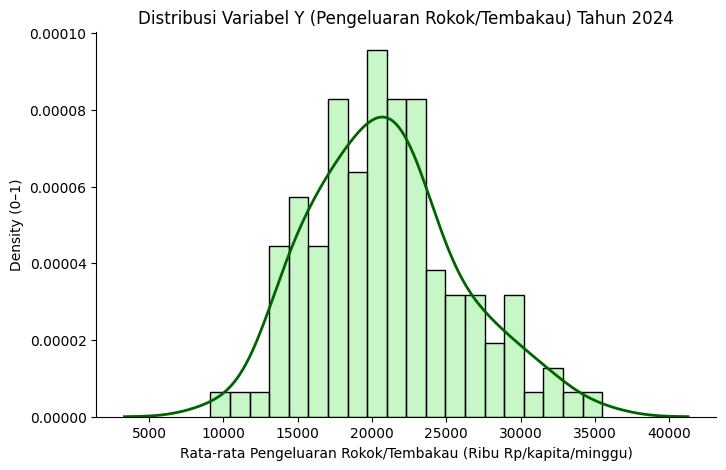

In [6]:
# Plot histogram + density variabel Y
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))

# Histogram dalam skala density (0–1)
sns.histplot(
    data=gdf,
    x="Y",
    stat="density",   # <- ini yang bikin skala 0–1
    bins=20,
    color="lightgreen",
    edgecolor="black",
    alpha=0.5
)

# Tambahkan kurva density
sns.kdeplot(
    data=gdf,
    x="Y",
    color="darkgreen",
    linewidth=2
)

# Label & judul
plt.xlabel("Rata-rata Pengeluaran Rokok/Tembakau (Ribu Rp/kapita/minggu)")
plt.ylabel("Density (0–1)")
plt.title("Distribusi Variabel Y (Pengeluaran Rokok/Tembakau) Tahun 2024")
sns.despine()
plt.show()

count      119.000000
mean     20897.361345
std       5015.590101
min       9126.000000
25%      17228.500000
50%      20486.000000
75%      23541.500000
max      35486.000000
Name: Y, dtype: float64


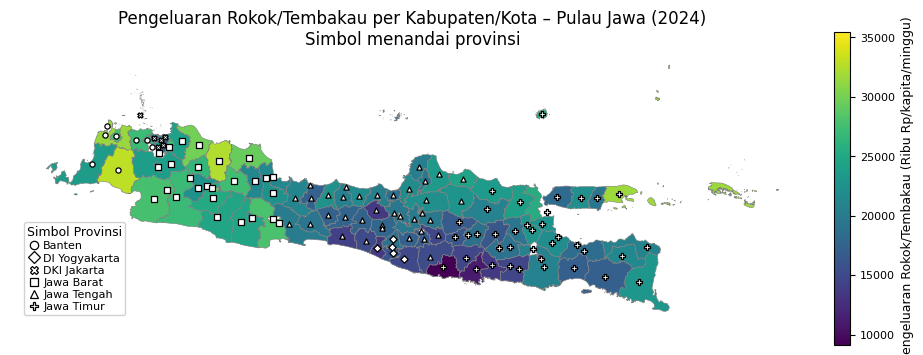

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import matplotlib as mpl
import numpy as np

# === 1. Statistik variabel Y ===
print(gdf["Y"].describe())

# === 2. Pastikan geometri valid ===
gdf = gdf.set_geometry(gdf.geometry.buffer(0))
jawa = jawa.set_geometry(jawa.geometry.buffer(0))

# === 3. Gabungkan shapefile Jawa dengan data Y ===
jawa_plot = jawa.merge(
    gdf[["Kabupaten/Kota", "Y"]],
    left_on="NAME_2", right_on="Kabupaten/Kota",
    how="left"
)

# === 4. Normalisasi nama provinsi ===
jawa_plot["NAME_1"] = jawa_plot["NAME_1"].replace({
    "Jakarta Raya": "DKI Jakarta",
    "Yogyakarta": "DI Yogyakarta"
})

# Tambahkan representative point untuk posisi simbol
jawa_plot["rep_pt"] = jawa_plot.geometry.representative_point()
jawa_plot["lon"] = jawa_plot["rep_pt"].x
jawa_plot["lat"] = jawa_plot["rep_pt"].y

# === 5. Mapping simbol per provinsi ===
ROV_MARKER = {
    "Banten": "o",
    "DKI Jakarta": "X",
    "Jawa Barat": "s",
    "Jawa Tengah": "^",
    "DI Yogyakarta": "D",
    "Jawa Timur": "P"
}
FALLBACK = ["v", "<", ">", "d", "p", "*"]

# === 6. Warna untuk choropleth ===
vmin, vmax = np.nanmin(jawa_plot["Y"]), np.nanmax(jawa_plot["Y"])
cmap = mpl.colormaps.get_cmap("viridis")
norm = Normalize(vmin=vmin, vmax=vmax)

# === 7. Plot peta ===
fig, ax = plt.subplots(figsize=(10, 6))

# Choropleth tanpa legend bawaan
jawa_plot.plot(
    column="Y",
    ax=ax,
    cmap=cmap,
    norm=norm,
    edgecolor="grey",
    linewidth=0.4,
    legend=False
)

# Tambahkan simbol provinsi
handles, seen = [], set()
for prov, sub in jawa_plot.groupby("NAME_1"):
    mk = ROV_MARKER.get(prov, FALLBACK[len(seen) % len(FALLBACK)])
    ax.scatter(sub["lon"], sub["lat"], marker=mk, s=14,
               facecolor="white", edgecolor="black", linewidth=0.9, zorder=4)
    if prov not in seen:
        handles.append(Line2D([0],[0], marker=mk, linestyle="",
                              markerfacecolor="white", markeredgecolor="black",
                              markeredgewidth=0.9, markersize=6, label=prov))
        seen.add(prov)

# Tambahkan colorbar manual
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, shrink=0.55, pad=0.02)
cbar.set_label("Pengeluaran Rokok/Tembakau (Ribu Rp/kapita/minggu)", fontsize=9)
cbar.ax.tick_params(labelsize=8)

# Legend simbol
leg = ax.legend(
    handles=handles,
    title="Simbol Provinsi",
    loc="lower left",
    bbox_to_anchor=(0.01, 0.01),
    frameon=True, framealpha=0.9,
    prop={'size': 8},
    title_fontsize=9,
    borderpad=0.3, labelspacing=0.2,
    handlelength=1.0, handletextpad=0.3
)
for h in leg.legend_handles:
    h.set_markersize(6)

# Judul
ax.set_title("Pengeluaran Rokok/Tembakau per Kabupaten/Kota – Pulau Jawa (2024)\nSimbol menandai provinsi")
ax.axis("off")

plt.tight_layout()
plt.show()


# Analisis Korelasi dan Multikolineritas

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# 1. Buat dataframe dari gdf (tanpa geometry)
df_sel = gdf.drop(columns="geometry").copy()

# 2. Tentukan variabel independen
ivs = ["X1", "X2", "X3", "X4", "X5L"]


# 3. Korelasi antara Y dan variabel independen
cor_matrix = df_sel[["Y"] + ivs].corr()
y_cors = cor_matrix.loc["Y", ivs]

print("Korelasi dengan Y (Pengeluaran Rokok/Tembakau):")
print(y_cors.abs().sort_values(ascending=False))

# 4. Cek multikolinearitas (VIF)
X = df_sel[ivs].fillna(0)
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

print("\nVariance Inflation Factors (VIF):")
print(vif_data)



Korelasi dengan Y (Pengeluaran Rokok/Tembakau):
X3     0.328761
X1     0.279307
X4     0.238197
X5L    0.086802
X2     0.064883
Name: Y, dtype: float64

Variance Inflation Factors (VIF):
  Variable         VIF
0    const  830.004995
1       X1    4.276643
2       X2    1.349714
3       X3    4.609582
4       X4    6.005739
5      X5L    5.970420


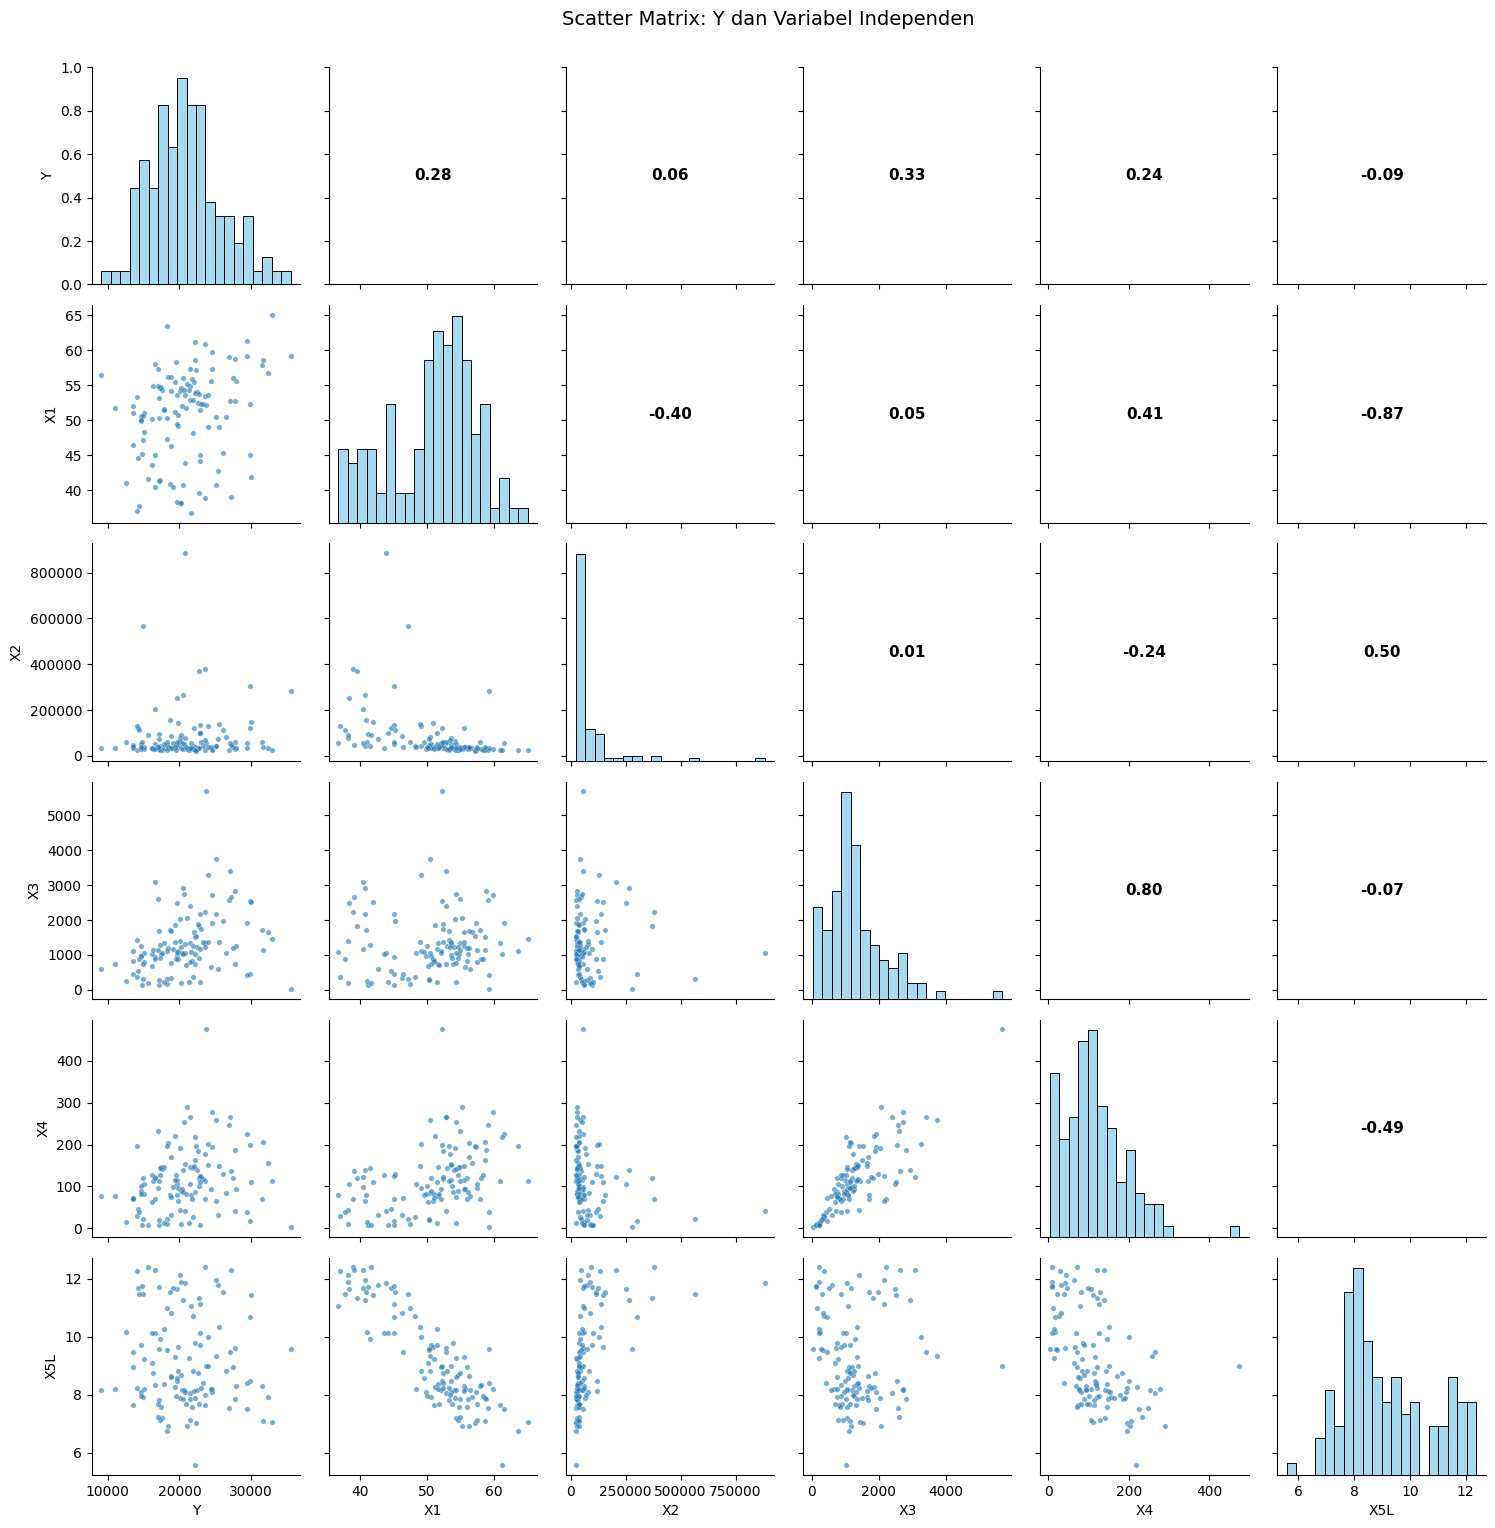

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 1. Variabel yang akan diplot
# ==========================
vars_to_plot = ["Y"] + ivs  # ivs = ["X1", "X2", "X3", "X4", "X5L"]
data = df_sel[vars_to_plot]

# ==========================
# 2. Buat PairGrid
# ==========================
g = sns.PairGrid(data, diag_sharey=False)

# Scatter plot di bagian bawah
g.map_lower(sns.scatterplot, s=15, alpha=0.6)

# Histogram di diagonal
g.map_diag(sns.histplot, kde=False, bins=20, color="skyblue")

# Fungsi untuk menampilkan korelasi di bagian atas
def corr_func(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(
        f"{r:.2f}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        ha="center", va="center",
        fontsize=11, fontweight="bold"
    )

g.map_upper(corr_func)

plt.suptitle("Scatter Matrix: Y dan Variabel Independen", fontsize=14, y=1.02)
plt.show()


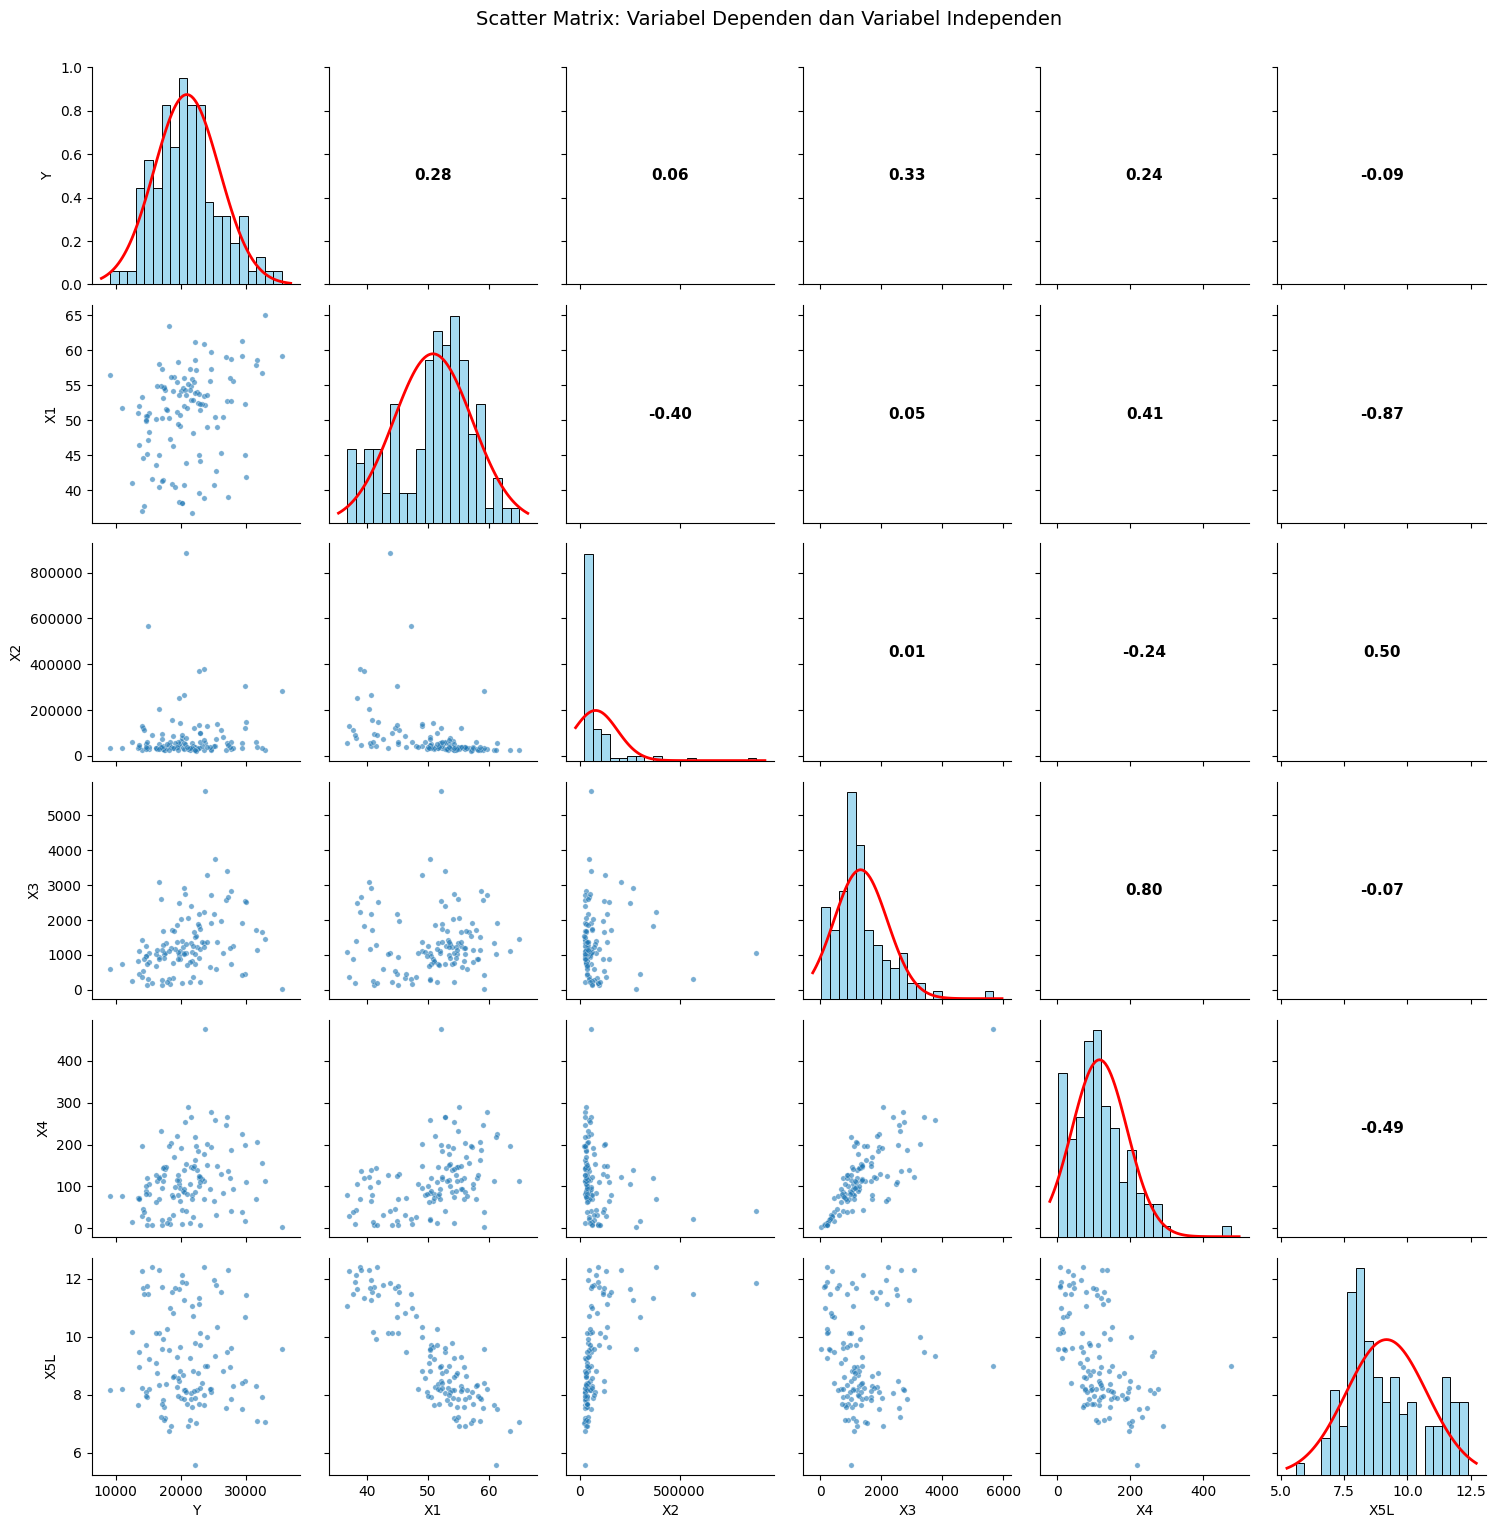

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# ==========================
# 1. Variabel yang akan diplot
# ==========================
vars_to_plot = ["Y"] + ivs  # ivs = ["X1", "X2", "X3", "X4", "X5L"]
data = df_sel[vars_to_plot]

# ==========================
# 2. Buat PairGrid
# ==========================
g = sns.PairGrid(data, diag_sharey=False)

# Scatter plot di bagian bawah
g.map_lower(sns.scatterplot, s=15, alpha=0.6)

# Histogram di diagonal + garis fit normal
def hist_with_norm(x, **kwargs):
    ax = plt.gca()
    sns.histplot(x, bins=20, kde=False, color="skyblue", ax=ax)

    # Fit distribusi normal
    mu, std = norm.fit(x)
    xmin, xmax = ax.get_xlim()
    x_fit = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x_fit, mu, std) * len(x) * (xmax - xmin)/20  # skala agar overlay sesuai histogram
    ax.plot(x_fit, p, 'r', linewidth=2)

g.map_diag(hist_with_norm)

# Korelasi di bagian atas
def corr_func(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(
        f"{r:.2f}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        ha="center", va="center",
        fontsize=11, fontweight="bold"
    )

g.map_upper(corr_func)

plt.suptitle("Scatter Matrix: Variabel Dependen dan Variabel Independen",
             fontsize=14, y=1.02)
plt.show()


# Analisis Korelasi untuk Agregat Data

Korelasi Data Kecamatan Jawa Timur

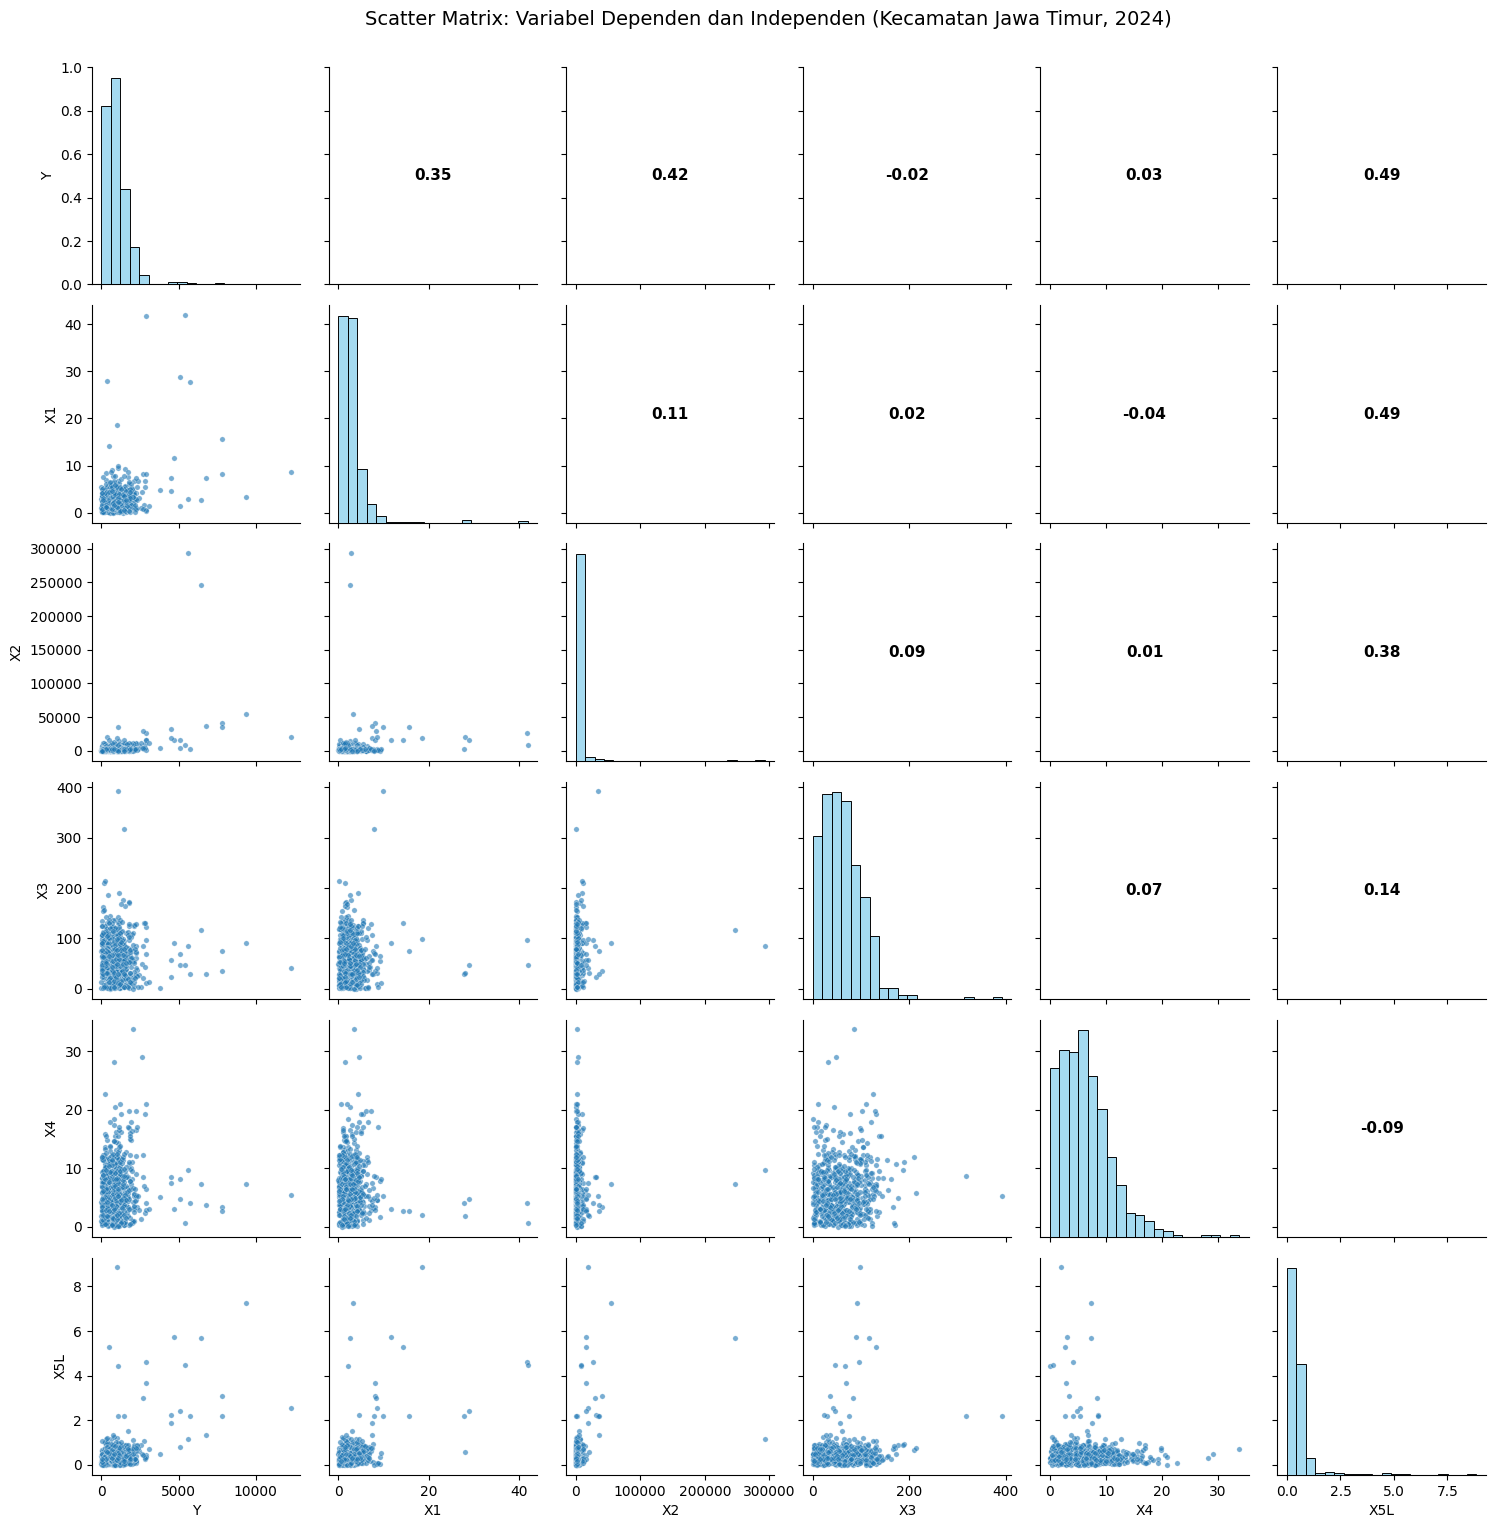

In [11]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests, zipfile, io
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# 1. Baca data Excel
# ==========================
df = pd.read_excel("../data/Data_Olah_Spasial.xlsx")

# Ambil variabel penting & filter tahun 2024
df = df[["Tahun", "Kabupaten/Kota", "LAT", "LONG", "Y", "X1", "X2", "X3", "X4", "X5L"]]
df = df[df["Tahun"] == 2024]

# ==========================
# 2. Ambil shapefile GADM level 3 (kecamatan)
# ==========================
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_IDN_shp.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("gadm_idn")

indo_kec = gpd.read_file("gadm_idn/gadm41_IDN_3.shp")

# Filter hanya Jawa Timur
jatim_kec = indo_kec[indo_kec["NAME_1"] == "Jawa Timur"].copy()
jatim_kec["Kabupaten_Kota"] = jatim_kec["NAME_2"].str.title()

# ==========================
# 3. Disagregasi data kabupaten ke kecamatan (pakai bobot normalisasi 0-1)
# ==========================
hasil_list = []

for _, row in df.iterrows():
    kab = row["Kabupaten/Kota"].title()

    # cari kecamatan di kabupaten tsb
    kecamatan = jatim_kec[jatim_kec["Kabupaten_Kota"] == kab].copy()
    if len(kecamatan) == 0:
        continue

    n = len(kecamatan)

    # buat nilai proporsi normalisasi 0-1
    disagg = {}
    for var in ["Y","X1","X2","X3","X4","X5L"]:
        w = np.random.rand(n)
        prop = w / w.sum()   # normalisasi
        disagg[var] = row[var] * prop

    for var in disagg:
        kecamatan[var] = disagg[var]

    hasil_list.append(kecamatan)

# ==========================
# 4. Gabungkan semua kecamatan hasil disagregasi
# ==========================
jatim_disagg = pd.concat(hasil_list, ignore_index=True)
jatim_disagg = gpd.GeoDataFrame(jatim_disagg, geometry="geometry", crs=indo_kec.crs)

# Buat dataframe tanpa geometry untuk scatter matrix
jatim_disagg_no_geom = jatim_disagg.drop(columns="geometry")

# ==========================
# 5. Scatter Matrix
# ==========================
vars_to_plot = ["Y","X1","X2","X3","X4","X5L"]
data = jatim_disagg_no_geom[vars_to_plot]

g = sns.PairGrid(data, diag_sharey=False)

# Scatter di bagian bawah
g.map_lower(sns.scatterplot, s=15, alpha=0.6)

# Histogram di diagonal
g.map_diag(sns.histplot, kde=False, bins=20, color="skyblue")

# Korelasi di bagian atas
def corr_func(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(
        f"{r:.2f}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        ha="center", va="center",
        fontsize=11, fontweight="bold"
    )

g.map_upper(corr_func)

plt.suptitle("Scatter Matrix: Variabel Dependen dan Independen (Kecamatan Jawa Timur, 2024)",
             fontsize=14, y=1.02)
plt.show()


Korelasi Data Kabupaten Jawa Timur

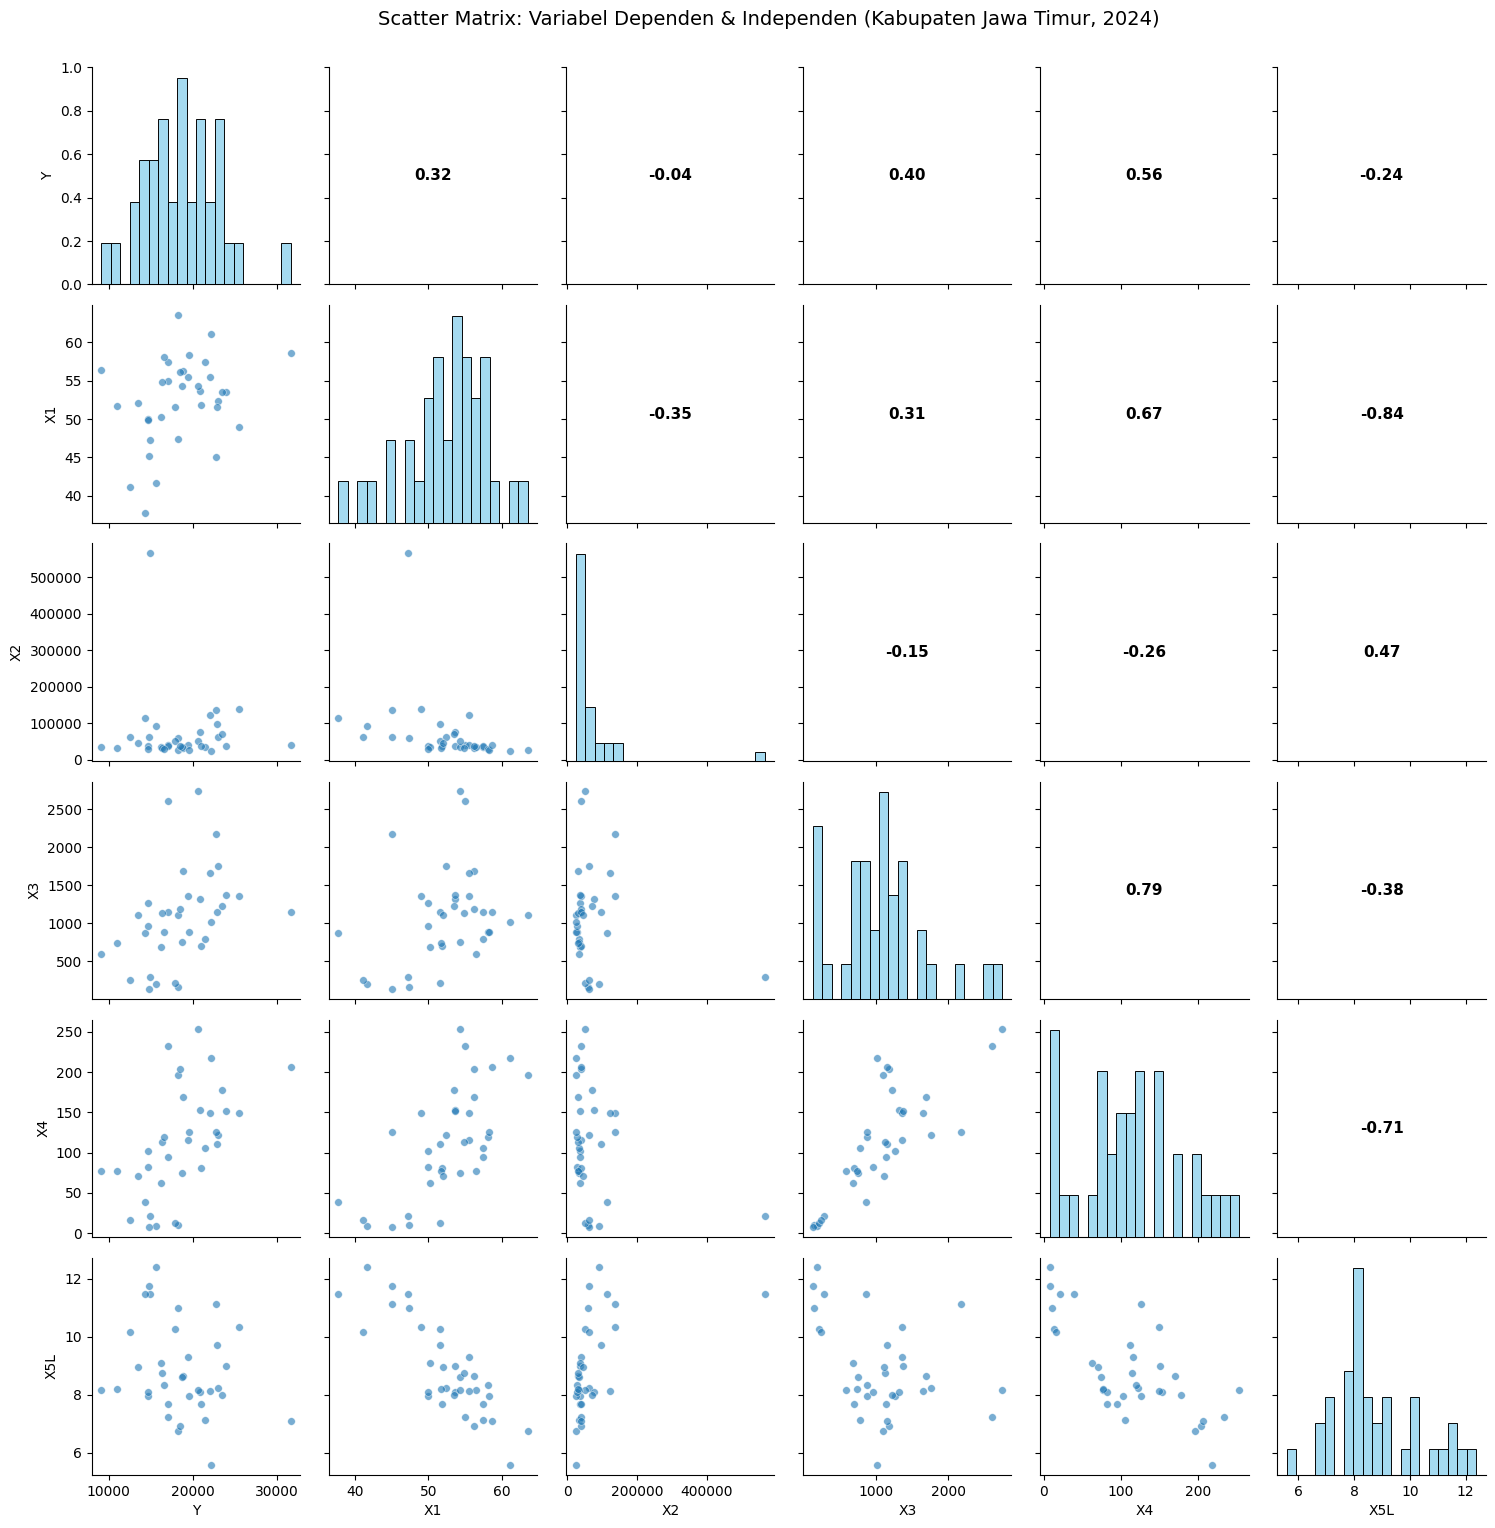

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==================================
# 1. Gabungkan shapefile + data Excel
# ==================================
# Merge dengan key Kabupaten/Kota
jawa_merge = jawa.merge(gdf, on="Kabupaten_Kota")

# Filter hanya Jawa Timur
jatim = jawa_merge[jawa_merge["NAME_1"] == "Jawa Timur"].copy()

# ==================================
# 2. Scatter Matrix Jawa Timur
# ==================================
vars_to_plot = ["Y","X1","X2","X3","X4","X5L"]
data = jatim[vars_to_plot]

g = sns.PairGrid(data, diag_sharey=False)

# Scatter di bagian bawah
g.map_lower(sns.scatterplot, s=30, alpha=0.6)

# Histogram di diagonal
g.map_diag(sns.histplot, kde=False, bins=20, color="skyblue")

# Korelasi di bagian atas
def corr_func(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(
        f"{r:.2f}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        ha="center", va="center",
        fontsize=11, fontweight="bold"
    )

g.map_upper(corr_func)

plt.suptitle("Scatter Matrix: Variabel Dependen & Independen (Kabupaten Jawa Timur, 2024)",
             fontsize=14, y=1.02)
plt.show()


# Regresi Linear Global (OLS)

Semua Variabel Terlibat

In [13]:
import statsmodels.formula.api as smf
from scipy.stats import kstest
import pandas as pd
import numpy as np

# 1. Definisikan model OLS
eq1 = "Y ~ X1 + X2 + X3 + X4 + X5L"

# 2. Estimasi model
model1 = smf.ols(formula=eq1, data=gdf).fit()

# 3. Ringkasan hasil estimasi
print(model1.summary())

# 4. Ambil koefisien dan p-value
params = model1.params
pvalues = model1.pvalues

# 5. Hitung MAPE (Mean Absolute Percentage Error)
residuals = model1.resid
Y_actual = gdf["Y"]
MAPE = (np.abs(residuals / Y_actual).mean()) * 100  # dalam persen

# 6. Uji normalitas residual (Kolmogorov-Smirnov)
residuals_std = (residuals - residuals.mean()) / residuals.std()
ks_stat, ks_p = kstest(residuals_std, 'norm')

# 7. Buat tabel ringkas
summary_table = pd.DataFrame({
    'Estimation': params,
    'p-value': pvalues
})

# Tambahkan statistik model di bawah tabel
model_stats = {
    'AIC': model1.aic,
    'MAPE (%)': MAPE,
    'Kolmogorov-Smirnov p-value': ks_p
}

print("\nRingkasan Parameter Estimasi & Statistik Model:")
print(summary_table)
print("\nStatistik Model:")
for key, value in model_stats.items():
    print(f"{key}: {value:.4f}")


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     10.12
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           4.98e-08
Time:                        07:48:32   Log-Likelihood:                -1160.2
No. Observations:                 119   AIC:                             2332.
Df Residuals:                     113   BIC:                             2349.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.995e+04   1.12e+04     -2.662      0.0

OLS 3 Variabel Utama

In [14]:
import statsmodels.formula.api as smf

# 1. Definisikan model OLS (sesuai hasil seleksi)
eq2 = "Y ~ X1 + X3 + X5L"

# 2. Estimasi model
model1 = smf.ols(formula=eq2, data=gdf).fit()

# 3. Ringkasan hasil estimasi
print(model1.summary())

from scipy.stats import shapiro

stat, p = shapiro(residuals)
print("Shapiro-Wilk Test")
print("Statistic:", stat, "p-value:", p)

# 4. Ambil koefisien dan p-value
params = model1.params
pvalues = model1.pvalues

# 5. Hitung MAPE (Mean Absolute Percentage Error)
residuals = model1.resid
Y_actual = gdf["Y"]
MAPE = (np.abs(residuals / Y_actual).mean()) * 100  # dalam persen

# 6a. Uji normalitas residual (Kolmogorov-Smirnov)
residuals_std = (residuals - residuals.mean()) / residuals.std()
ks_stat, ks_p = kstest(residuals_std, 'norm')

# 6b. Uji normalitas residual tambahan (Shapiro-Wilk)
sw_stat, sw_p = shapiro(residuals)
print("\nShapiro-Wilk Test")
print("Statistic:", sw_stat, "p-value:", sw_p)

# 7. Buat tabel ringkas
summary_table = pd.DataFrame({
    'Estimation': params,
    'p-value': pvalues
})

# 8. Tambahkan statistik model di bawah tabel
model_stats = {
    'AIC': model1.aic,
    'MAPE (%)': MAPE,
    'Kolmogorov-Smirnov p-value': ks_p
}

print("\nRingkasan Parameter Estimasi & Statistik Model:")
print(summary_table)
print("\nStatistik Model:")
for key, value in model_stats.items():
    print(f"{key}: {value:.4f}")

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     15.80
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           1.14e-08
Time:                        07:48:32   Log-Likelihood:                -1161.7
No. Observations:                 119   AIC:                             2331.
Df Residuals:                     115   BIC:                             2343.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.598e+04   1.07e+04     -3.361      0.0

# Pemilihan Bandwith untuk GWR

In [15]:
from mgwr.sel_bw import Sel_BW
import numpy as np

# 1. Siapkan koordinat (LONG, LAT) dari data gdf
coords = np.array(list(zip(gdf["LONG"], gdf["LAT"])))

# 2. Variabel dependen (Y) dan independen (X1, X3, X5L)
y = gdf["Y"].values.reshape((-1, 1))
X = gdf[["X1", "X3", "X5L"]].values

# 3. Cari bandwidth optimal (Gaussian, fixed, spherical)
selector = Sel_BW(
    coords, y, X,
    kernel="gaussian",   # pembobotan Gaussian
    fixed=True,          # bandwidth tetap
    spherical=True       # jarak dihitung di permukaan bumi
)                        # Pemilihan ini didasarkan pada nilai AICc

# 4. Hitung bandwidth optimal
fbw = selector.search(bw_min=2)

print("Optimal bandwidth (Gaussian, fixed, spherical):", fbw)


Optimal bandwidth (Gaussian, fixed, spherical): 77.08


# Validasi Bandwith Optimal

In [16]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import numpy as np

# 1. Siapkan koordinat
coords = np.array(list(zip(gdf["LONG"], gdf["LAT"])))

# 2. Variabel
y = gdf["Y"].values.reshape((-1, 1))
X = gdf[["X1", "X3", "X5L"]].values

# 3. Buat selector
selector = Sel_BW(
    coords, y, X,
    kernel="gaussian",
    fixed=True,
    spherical=True
)

# 4. Kandidat bandwidth untuk dicek
candidate_bw = [50, 60, 70, 77, 80, 90, 100]
results = []

for bw in candidate_bw:
    gwr = GWR(coords, y, X, bw, fixed=True, kernel='gaussian', spherical=True)
    gwr_results = gwr.fit()
    results.append((bw, gwr_results.aicc))

# 5. Tampilkan hasil
print("BW   |   AICc")
for bw, aicc in results:
    print(f"{bw:<4} | {aicc:.2f}")

# 6. Cari bandwidth optimal otomatis
fbw = selector.search(bw_min=2)
print("\nOptimal bandwidth (AICc):", fbw)


BW   |   AICc
50   | 2291.75
60   | 2283.92
70   | 2281.93
77   | 2281.68
80   | 2281.71
90   | 2282.16
100  | 2282.92

Optimal bandwidth (AICc): 77.08


# Geographically Weighted Regression (GWR)

In [17]:
from mgwr.gwr import GWR
import numpy as np

# 1. Siapkan ulang data
coords = np.array(list(zip(gdf["LONG"], gdf["LAT"])))
y = gdf["Y"].values.reshape((-1, 1))
X = gdf[["X1", "X3", "X5L"]].values

# 2. Fit GWR model dengan bandwidth hasil seleksi sebelumnya (fbw)
gwr_model = GWR(coords, y, X, bw=fbw, fixed=True, kernel="gaussian", spherical=True)
gwr_results = gwr_model.fit()

# 3. Ringkasan hasil
print(gwr_results.summary())

# 4. Kalau mau akses hasil detail:
betas = gwr_results.params        # koefisien lokal per wilayah
residuals = gwr_results.resid_response
influence = gwr_results.influ     # nilai diagonal hat matrix
se = gwr_results.bse              # standard errors lokal


Model type                                                         Gaussian
Number of observations:                                                 119
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       2101887561.199
Log-likelihood:                                                   -1161.729
AIC:                                                               2331.458
AICc:                                                              2333.989
BIC:                                                           2101887011.599
R2:                                                                   0.292
Adj. R2:                                                              0.273

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- --

In [18]:
from mgwr.gwr import GWR
import numpy as np
import pandas as pd
from scipy.stats import kstest

# 1. Siapkan data
coords = np.array(list(zip(gdf["LONG"], gdf["LAT"])))
y = gdf["Y"].values.reshape((-1, 1))
X = gdf[["X1", "X3", "X5L"]].values

# 2. Fit GWR model dengan bandwidth hasil seleksi (fbw)
gwr_model = GWR(coords, y, X, bw=fbw, fixed=True, kernel="gaussian", spherical=True)
gwr_results = gwr_model.fit()

# 3. Ringkasan hasil
print(gwr_results.summary())

# 4. Ambil koefisien lokal (params) dan residual
betas = gwr_results.params        # koefisien lokal per wilayah
residuals = gwr_results.resid_response

# 5. Hitung MAPE (Mean Absolute Percentage Error)
Y_actual = y
MAPE = (np.abs(residuals / Y_actual).mean()) * 100  # dalam persen

# 6. Uji normalitas residual (Kolmogorov-Smirnov)
residuals_std = (residuals - residuals.mean()) / residuals.std()
ks_stat, ks_p = kstest(residuals_std, 'norm')

# 7. Buat ringkasan koefisien rata-rata per variabel
coef_summary = pd.DataFrame({
    'Estimation (mean)': betas.mean(axis=0),
})

# 8. Statistik model ringkas
model_stats = {
    'MAPE (%)': MAPE,
    'Kolmogorov-Smirnov p-value': ks_p
}

print("\nRingkasan Estimasi Koefisien GWR (rata-rata per variabel):")
print(coef_summary)
print("\nStatistik Model GWR:")
for key, value in model_stats.items():
    print(f"{key}: {value:.4f}")


Model type                                                         Gaussian
Number of observations:                                                 119
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       2101887561.199
Log-likelihood:                                                   -1161.729
AIC:                                                               2331.458
AICc:                                                              2333.989
BIC:                                                           2101887011.599
R2:                                                                   0.292
Adj. R2:                                                              0.273

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- --

#GWR Kab. Sumenep

In [19]:
def get_local_gwr(gwr_results, gdf, target):
    """
    Ambil koefisien, SE, Local R², dan prediksi GWR untuk 1 kabupaten/kota
    ----------
    target : str
        Nama daerah (misal: "Bandung", "Jakarta", "Surabaya", "Sumenep")
    """
    # --- 1. Cari indeks lokasi ---
    idx = gdf[gdf["Kabupaten/Kota"].str.contains(target, case=False, na=False)].index[0]

    # --- 2. Ambil nilai lokal ---
    coef = gwr_results.params[idx, :]
    se   = gwr_results.bse[idx, :]
    r2   = float(np.ravel(gwr_results.localR2[idx])[0])

    # --- 3. Hitung nilai prediksi (interpolasi lokal) ---
    X_local = gdf.loc[idx, ["X1", "X3", "X5L"]].values
    y_hat   = coef[0] + np.dot(coef[1:], X_local)

    # --- 4. Cetak ringkasan ---
    print("=" * 60)
    print(f"📍 Koefisien Lokal GWR untuk {target}")
    print("-" * 60)
    for var, c, s in zip(["Intercept", "X1", "X3", "X5L"], coef, se):
        print(f"{var:10s}: {c:12.4f}   (SE={s:.4f})")

    print(f"\nLocal R² : {r2:.4f}")
    print(f"\n🔮 Interpolasi Y di {target}: {y_hat:.4f}")
    print("=" * 60 + "\n")

    # --- 5. Return hasil dalam dict ---
    return {
        "target": target,
        "coef": coef,
        "se": se,
        "localR2": r2,
        "prediksi": y_hat
    }

hasil_sumenep = get_local_gwr(gwr_results, gdf, "Sumenep")
y_hat_sumenep = hasil_sumenep["prediksi"]



📍 Koefisien Lokal GWR untuk Sumenep
------------------------------------------------------------
Intercept :    7255.8642   (SE=23415.7380)
X1        :     272.2192   (SE=280.3669)
X3        :       1.5269   (SE=1.0030)
X5L       :    -272.5370   (SE=1081.5439)

Local R² : 0.3289

🔮 Interpolasi Y di Sumenep: 23041.8398



# Visualisasi Local R^2

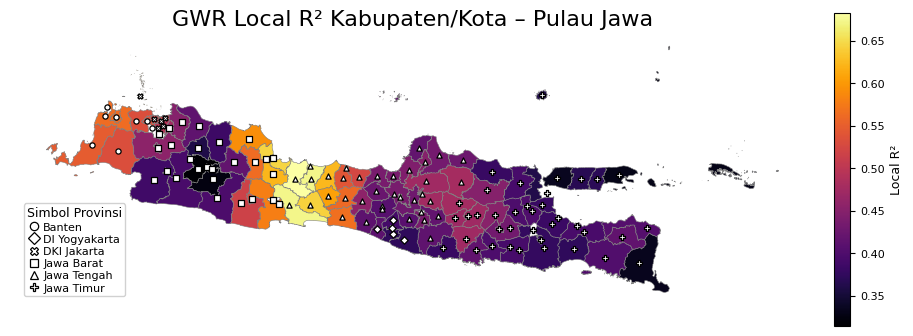

In [20]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import matplotlib as mpl
import numpy as np

# --- 1. Fit model & ambil Local R² ---
gwr_results = gwr_model.fit()
gdf["localR2"] = gwr_results.localR2

# --- 2. Samakan key untuk join ---
gdf["Kabupaten_Kota"] = gdf["Kabupaten/Kota"].str.title()
jawa["Kabupaten_Kota"] = jawa["NAME_2"].str.title()

# --- 3. Gabungkan hasil GWR ke shapefile Jawa ---
jawa_gwr = jawa.merge(
    gdf[["Kabupaten_Kota", "localR2"]],
    on="Kabupaten_Kota", how="left"
)

# --- 4. Normalisasi nama provinsi ---
jawa_gwr["NAME_1"] = jawa_gwr["NAME_1"].replace({
    "Jakarta Raya": "DKI Jakarta",
    "Yogyakarta": "DI Yogyakarta"
})

# --- 5. Tambahkan representative point untuk simbol ---
jawa_gwr["rep_pt"] = jawa_gwr.geometry.representative_point()
jawa_gwr["lon"] = jawa_gwr["rep_pt"].x
jawa_gwr["lat"] = jawa_gwr["rep_pt"].y

# --- 6. Mapping simbol per provinsi ---
ROV_MARKER = {
    "Banten": "o",
    "DKI Jakarta": "X",
    "Jawa Barat": "s",
    "Jawa Tengah": "^",
    "DI Yogyakarta": "D",
    "Jawa Timur": "P"
}
FALLBACK = ["v", "<", ">", "d", "p", "*"]

# --- 7. Warna untuk choropleth ---
vmin, vmax = np.nanmin(jawa_gwr["localR2"]), np.nanmax(jawa_gwr["localR2"])
cmap = mpl.colormaps.get_cmap("inferno")
norm = Normalize(vmin=vmin, vmax=vmax)

# --- 8. Plot peta ---
fig, ax = plt.subplots(figsize=(10, 6))

# Choropleth tanpa legend bawaan
jawa_gwr.plot(
    column="localR2",
    ax=ax,
    cmap=cmap,
    norm=norm,
    edgecolor="grey",
    linewidth=0.4,
    legend=False
)

# Tambahkan simbol provinsi
handles, seen = [], set()
for prov, sub in jawa_gwr.groupby("NAME_1"):
    mk = ROV_MARKER.get(prov, FALLBACK[len(seen) % len(FALLBACK)])
    ax.scatter(sub["lon"], sub["lat"], marker=mk, s=14,
               facecolor="white", edgecolor="black", linewidth=0.9, zorder=4)
    if prov not in seen:
        handles.append(Line2D([0],[0], marker=mk, linestyle="",
                              markerfacecolor="white", markeredgecolor="black",
                              markeredgewidth=0.9, markersize=6, label=prov))
        seen.add(prov)

# Colorbar manual
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, shrink=0.55, pad=0.02)
cbar.set_label("Local R²", fontsize=9)
cbar.ax.tick_params(labelsize=8)

# Legend simbol
leg = ax.legend(
    handles=handles,
    title="Simbol Provinsi",
    loc="lower left",
    bbox_to_anchor=(0.01, 0.01),
    frameon=True, framealpha=0.9,
    prop={'size': 8},
    title_fontsize=9,
    borderpad=0.3, labelspacing=0.2,
    handlelength=1.0, handletextpad=0.3
)
for h in leg.legend_handles:
    h.set_markersize(6)

# --- 9. Judul & style ---
ax.set_title("GWR Local R² Kabupaten/Kota – Pulau Jawa", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.show()


# Visualisasi Koefisien Lokal GWR per Variabel

In [21]:
# --- 1. Masukkan koefisien lokal hasil GWR ke dataframe hasil GWR ---
gdf["beta_X1"]  = betas[:, 0]   # kolom pertama untuk X1
gdf["beta_X3"]  = betas[:, 1]   # kolom kedua untuk X3
gdf["beta_X5L"] = betas[:, 2]   # kolom ketiga untuk X5L

# --- 2. Samakan nama key agar bisa merge ---
gdf["Kabupaten_Kota"] = gdf["Kabupaten/Kota"].str.title()
jawa["Kabupaten_Kota"] = jawa["NAME_2"].str.title()

# --- 3. Gabungkan koefisien lokal ke shapefile Jawa ---
jawa_gwr = jawa.merge(
    gdf[["Kabupaten_Kota", "beta_X1", "beta_X3", "beta_X5L"]],
    on="Kabupaten_Kota",
    how="left"
)

# --- 4. Siapkan geometri provinsi untuk label ---
jawa["NAME_1"] = jawa["NAME_1"].replace({
    "Jakarta Raya": "DKI Jakarta",
    "Yogyakarta": "DI Yogyakarta"
})
prov = jawa.dissolve(by="NAME_1")
prov["coords"] = prov.geometry.centroid


/tmp/ipykernel_10592/2245363064.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  prov["coords"] = prov.geometry.centroid


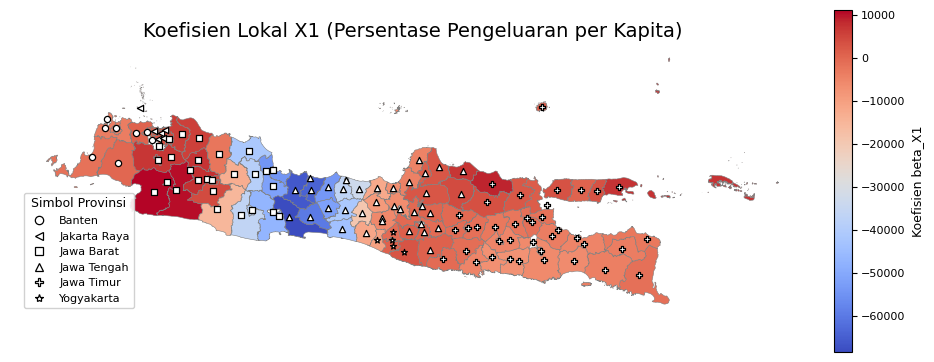

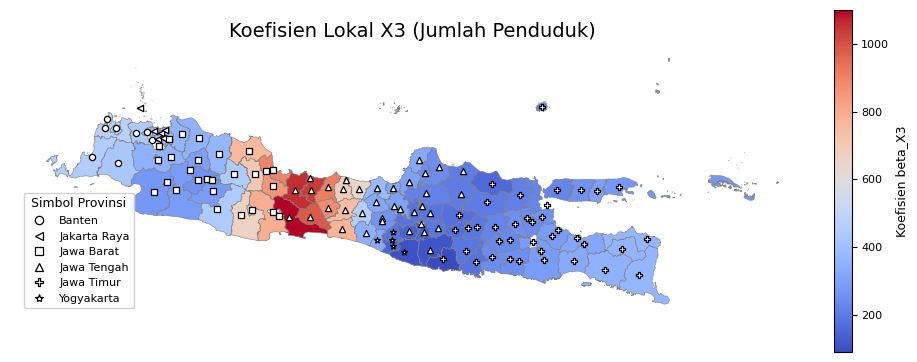

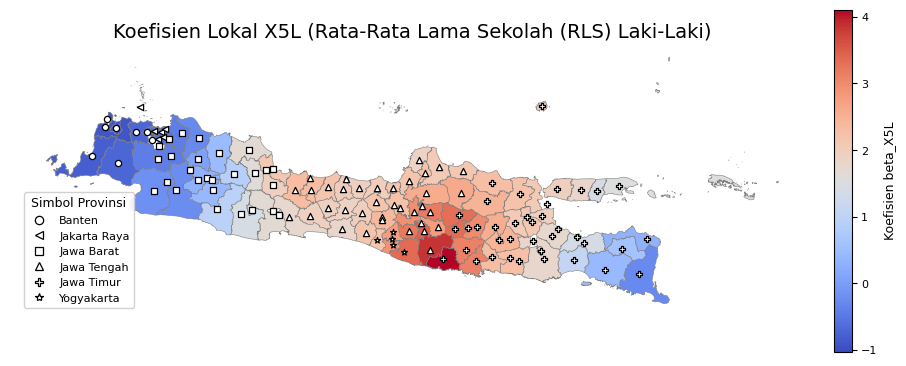

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
#--- 1. Tambahkan koefisien lokal ke gdf ---
gdf["beta_X1"] = betas[:, 0] # koefisien lokal untuk X1
gdf["beta_X3"] = betas[:, 1] # koefisien lokal untuk X3
gdf["beta_X5L"] = betas[:, 2] # koefisien lokal untuk X5L

# -----------------------------
# DEFINISI SIMBOL PER PROVINSI
# -----------------------------
PROV_MARKER = {
    "Banten": "o",
    "DKI Jakarta": "X",
    "Jawa Barat": "s",
    "Jawa Tengah": "^",
    "DI Yogyakarta": "D",
    "Jawa Timur": "P"
}
FALLBACK = ["v", "<", ">", "d", "p", "*"]

# -----------------------------
# FUNGSI UNTUK PLOTTING KOEFISIEN
# -----------------------------
def plot_beta(df, prov, column, title):
    # pastikan CRS = WGS84 (epsg:4326)
    df = df.to_crs(epsg=4326).copy()
    df["rep_pt"] = df.geometry.representative_point()
    df["lon"] = df["rep_pt"].x
    df["lat"] = df["rep_pt"].y

    # range nilai koefisien
    vmin = np.nanmin(df[column])
    vmax = np.nanmax(df[column])
    cmap = mpl.colormaps.get_cmap("coolwarm")
    norm = Normalize(vmin=vmin, vmax=vmax)

    fig, ax = plt.subplots(figsize=(10, 6))

    # choropleth peta
    df.plot(column=column, cmap=cmap, norm=norm,
            edgecolor="grey", linewidth=0.4,
            ax=ax, legend=False)

    # titik marker per provinsi
    handles, seen = [], set()
    for prov_name, sub in df.groupby("NAME_1"):
        mk = PROV_MARKER.get(prov_name, FALLBACK[len(seen) % len(FALLBACK)])
        ax.scatter(sub["lon"], sub["lat"], marker=mk, s=20,
                   facecolor="white", edgecolor="black", linewidth=0.9, zorder=4)
        if prov_name not in seen:
            handles.append(Line2D([0],[0], marker=mk, linestyle="",
                                  markerfacecolor="white", markeredgecolor="black",
                                  markeredgewidth=0.9, markersize=6, label=prov_name))
            seen.add(prov_name)

    # colorbar kecil
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array([])
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.02)
    cbar.set_label(f"Koefisien {column}", fontsize=9)
    cbar.ax.tick_params(labelsize=8)

    # legend simbol provinsi
    leg = ax.legend(handles=handles, title="Simbol Provinsi",
                    loc="lower left", bbox_to_anchor=(0.01,0.01),
                    frameon=True, framealpha=0.9,
                    prop={'size':8}, title_fontsize=9)
    for h in leg.legend_handles:
        h.set_markersize(6)

    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


# -----------------------------
# CONTOH PANGGIL FUNGSI
# -----------------------------
# asumsi kamu sudah punya GeoDataFrame:
# jawa_gwr  -> hasil GWR (ada kolom beta_X1, beta_X3, beta_X5L)
# prov      -> boundary provinsi (GeoDataFrame)

plot_beta(jawa_gwr, prov, "beta_X1", "Koefisien Lokal X1 (Persentase Pengeluaran per Kapita)")
plot_beta(jawa_gwr, prov, "beta_X3", "Koefisien Lokal X3 (Jumlah Penduduk)")
plot_beta(jawa_gwr, prov, "beta_X5L", "Koefisien Lokal X5L (Rata-Rata Lama Sekolah (RLS) Laki-Laki)")


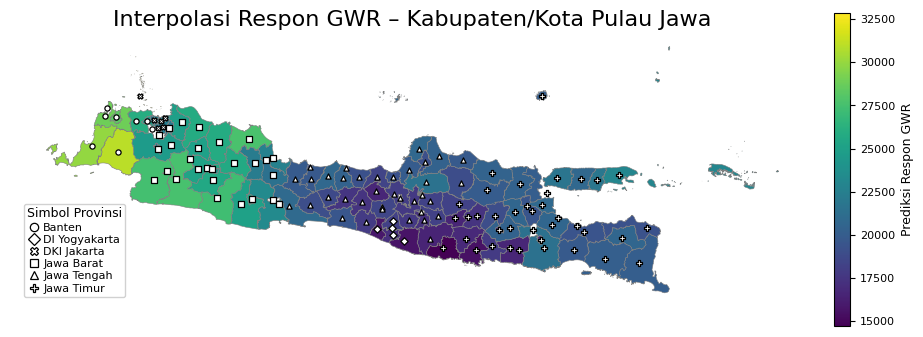

In [23]:
# --- 1. Hitung prediksi GWR ---
gdf["prediksi"] = gwr_results.predy  # prediksi respon di tiap lokasi

# --- 2. Gabungkan prediksi ke shapefile Jawa ---
jawa_pred = jawa.merge(
    gdf[["Kabupaten_Kota", "prediksi"]],
    on="Kabupaten_Kota", how="left"
)

# --- 3. Tambahkan representative point untuk simbol ---
jawa_pred["rep_pt"] = jawa_pred.geometry.representative_point()
jawa_pred["lon"] = jawa_pred["rep_pt"].x
jawa_pred["lat"] = jawa_pred["rep_pt"].y

# --- 4. Warna untuk choropleth prediksi ---
vmin, vmax = np.nanmin(jawa_pred["prediksi"]), np.nanmax(jawa_pred["prediksi"])
cmap = mpl.colormaps.get_cmap("viridis")
norm = Normalize(vmin=vmin, vmax=vmax)

# --- 5. Plot peta prediksi ---
fig, ax = plt.subplots(figsize=(10,6))

# Choropleth
jawa_pred.plot(
    column="prediksi",
    ax=ax,
    cmap=cmap,
    norm=norm,
    edgecolor="grey",
    linewidth=0.4,
    legend=False
)

# Tambahkan simbol provinsi
handles, seen = [], set()
for prov, sub in jawa_pred.groupby("NAME_1"):
    mk = ROV_MARKER.get(prov, FALLBACK[len(seen) % len(FALLBACK)])
    ax.scatter(sub["lon"], sub["lat"], marker=mk, s=14,
               facecolor="white", edgecolor="black", linewidth=0.9, zorder=4)
    if prov not in seen:
        handles.append(Line2D([0],[0], marker=mk, linestyle="",
                              markerfacecolor="white", markeredgecolor="black",
                              markeredgewidth=0.9, markersize=6, label=prov))
        seen.add(prov)

# Colorbar manual
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, shrink=0.55, pad=0.02)
cbar.set_label("Prediksi Respon GWR", fontsize=9)
cbar.ax.tick_params(labelsize=8)

# Legend simbol
leg = ax.legend(
    handles=handles,
    title="Simbol Provinsi",
    loc="lower left",
    bbox_to_anchor=(0.01, 0.01),
    frameon=True, framealpha=0.9,
    prop={'size': 8},
    title_fontsize=9,
    borderpad=0.3, labelspacing=0.2,
    handlelength=1.0, handletextpad=0.3
)
for h in leg.legend_handles:
    h.set_markersize(6)

# --- 6. Judul & style ---
ax.set_title("Interpolasi Respon GWR – Kabupaten/Kota Pulau Jawa", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.show()


(<Figure size 1000x600 with 2 Axes>,
 <Axes: title={'center': 'Interpolasi Respon GWR – Kabupaten/Kota Pulau Jawa'}>)

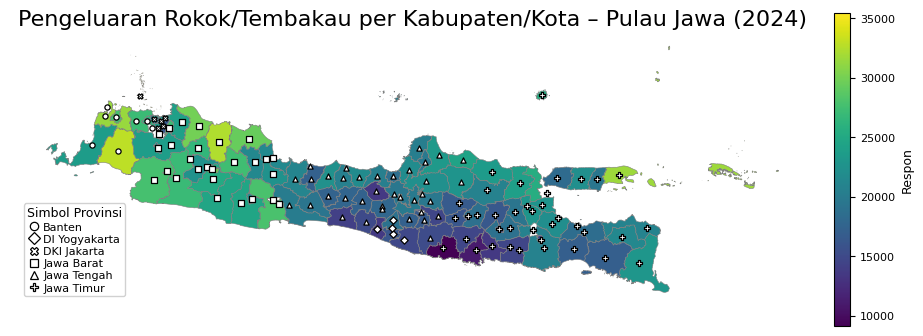

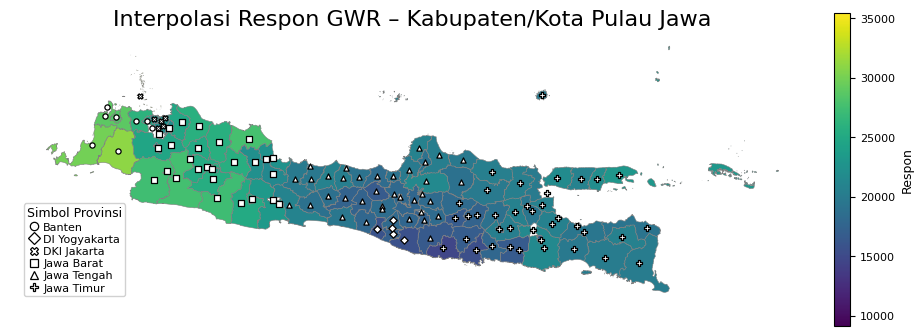

In [24]:
# Tentukan vmin & vmax global agar skala sama
vmin = min(np.nanmin(jawa_pred["prediksi"]), np.nanmin(jawa_plot["Y"]))
vmax = max(np.nanmax(jawa_pred["prediksi"]), np.nanmax(jawa_plot["Y"]))

# Ubah fungsi plot_choropleth agar menerima norm eksternal
def plot_choropleth_fixed(gdf, col, title, cbar_label, norm):
    fig, ax = plt.subplots(figsize=(10,6))
    cmap = mpl.colormaps.get_cmap("viridis")

    # Choropleth
    gdf.plot(column=col, ax=ax, cmap=cmap, norm=norm,
             edgecolor="grey", linewidth=0.4, legend=False)

    # Simbol provinsi
    handles, seen = [], set()
    for prov, sub in gdf.groupby("NAME_1"):
        mk = ROV_MARKER.get(prov, FALLBACK[len(seen) % len(FALLBACK)])
        ax.scatter(sub["lon"], sub["lat"], marker=mk, s=14,
                   facecolor="white", edgecolor="black", linewidth=0.9, zorder=4)
        if prov not in seen:
            handles.append(Line2D([0],[0], marker=mk, linestyle="",
                                  markerfacecolor="white", markeredgecolor="black",
                                  markeredgewidth=0.9, markersize=6, label=prov))
            seen.add(prov)

    # Colorbar manual
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array([])
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.55, pad=0.02)
    cbar.set_label(cbar_label, fontsize=9)
    cbar.ax.tick_params(labelsize=8)

    # Legend simbol
    leg = ax.legend(handles=handles, title="Simbol Provinsi",
                    loc="lower left", bbox_to_anchor=(0.01,0.01),
                    frameon=True, framealpha=0.9,
                    prop={'size': 8}, title_fontsize=9,
                    borderpad=0.3, labelspacing=0.2,
                    handlelength=1.0, handletextpad=0.3)
    for h in leg.legend_handles:
        h.set_markersize(6)

    ax.set_title(title, fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    return fig, ax

# Buat norm global
norm_global = Normalize(vmin=vmin, vmax=vmax)

# Plot prediksi dan aktual dengan skala yang sama
plot_choropleth_fixed(jawa_plot, "Y",
                      "Pengeluaran Rokok/Tembakau per Kabupaten/Kota – Pulau Jawa (2024)",
                      "Respon", norm_global)

plot_choropleth_fixed(jawa_pred, "prediksi",
                      "Interpolasi Respon GWR – Kabupaten/Kota Pulau Jawa",
                      "Respon", norm_global)

# Disagregasi Sumenep

📍 Koefisien Lokal GWR untuk Sumenep
------------------------------------------------------------
Intercept :    7255.8642   (SE=23415.7380)
X1        :     272.2192   (SE=280.3669)
X3        :       1.5269   (SE=1.0030)
X5L       :    -272.5370   (SE=1081.5439)

Local R² : 0.3289

🔮 Interpolasi Y di Sumenep: 23041.8398



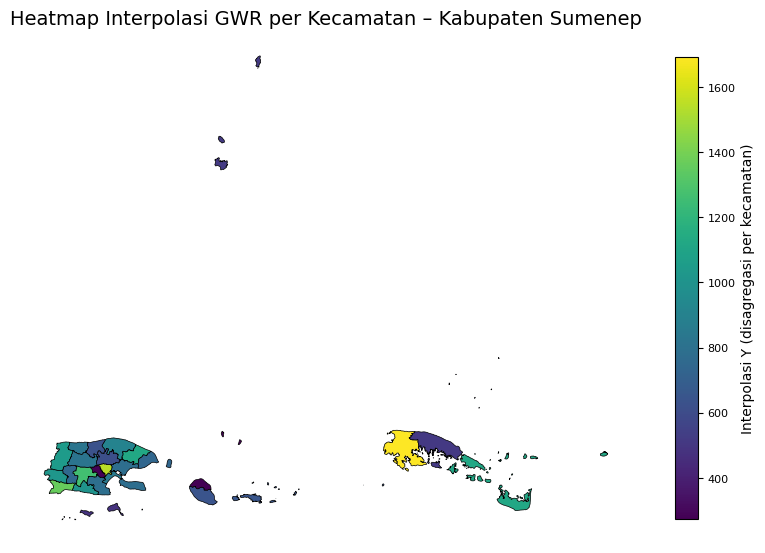

In [27]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib as mpl
import requests, zipfile, io

# ===============================
# 1. Ambil prediksi GWR Sumenep
# ===============================
hasil_sumenep = get_local_gwr(gwr_results, gdf, "Sumenep")
y_hat_sumenep = hasil_sumenep["prediksi"]

# ===============================
# 2. Baca data disagregasi per kecamatan
# ===============================
disag = pd.read_excel("../data/Disagregasi_Data.xlsx")
disag_sumenep = disag[disag["Kabupaten"].str.contains("Sumenep", case=False, na=False)].copy()

# ===============================
# 3. Hitung proporsi penduduk & prediksi per kecamatan
# ===============================
total_pop = disag_sumenep["Jumlah Penduduk"].sum()
disag_sumenep["proporsi"] = disag_sumenep["Jumlah Penduduk"] / total_pop
disag_sumenep["prediksi_Y"] = disag_sumenep["proporsi"] * y_hat_sumenep

# ===============================
# 4. Download dan baca GADM level 3 (kecamatan)
# ===============================
#url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_IDN_shp.zip"
#r = requests.get(url)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall("gadm_idn")
gadm3 = gpd.read_file("../gadm_idn/gadm41_IDN_3.shp")

# ===============================
# 5. Filter hanya Kecamatan di Kabupaten Sumenep
# ===============================
sumenep_gadm = gadm3[gadm3["NAME_2"].str.contains("Sumenep", case=False, na=False)].copy()

# ===============================
# 6. Gabungkan shapefile kecamatan dengan data disagregasi
# ===============================
# Pastikan nama kecamatan di disag_sumenep sama formatnya dengan NAME_3
sumenep_gadm = sumenep_gadm.merge(
    disag_sumenep[["Kecamatan", "prediksi_Y"]],
    left_on="NAME_3",
    right_on="Kecamatan",
    how="left"
)

# ===============================
# 7. Atur colormap
# ===============================
vmin, vmax = sumenep_gadm["prediksi_Y"].min(), sumenep_gadm["prediksi_Y"].max()
cmap = mpl.colormaps.get_cmap("viridis")
norm = Normalize(vmin=vmin, vmax=vmax)

# ===============================
# 8. Plot choropleth per kecamatan
# ===============================
fig, ax = plt.subplots(figsize=(10, 10))
sumenep_gadm.plot(
    ax=ax,
    column="prediksi_Y",
    cmap=cmap,
    norm=norm,
    edgecolor="black",
    linewidth=0.5
)

# Tambahkan colorbar manual
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, shrink=0.6)
cbar.set_label("Interpolasi Y (disagregasi per kecamatan)", fontsize=10)
cbar.ax.tick_params(labelsize=8)

ax.set_title("Heatmap Interpolasi GWR per Kecamatan – Kabupaten Sumenep", fontsize=14)
ax.set_axis_off()
plt.show()

# ===============================
# 9. Simpan hasil ke Excel (opsional)
# ===============================
sumenep_gadm[["NAME_3", "prediksi_Y"]].to_excel("Disagregasi_Sumenep_Level3.xlsx", index=False)


# Peta Interaktif

In [28]:
import folium
import geopandas as gpd
import pandas as pd

# Pastikan CRS WGS84
sumenep_gadm = sumenep_gadm.to_crs(epsg=4326)

# Ambil centroid untuk memposisikan awal peta
centroid = sumenep_gadm.geometry.centroid.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=10)

# Tambahkan choropleth per kecamatan
folium.Choropleth(
    geo_data=sumenep_gadm,
    data=sumenep_gadm,
    columns=["NAME_3", "prediksi_Y"],
    key_on="feature.properties.NAME_3",
    fill_color="viridis",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Prediksi Y (disagregasi per kecamatan)"
).add_to(m)

# Tambahkan popup interaktif per kecamatan
for _, row in sumenep_gadm.iterrows():
    folium.GeoJson(
        row["geometry"],
        style_function=lambda feature, alpha=0.7: {
            'fillColor': 'transparent',
            'color': 'black',
            'weight': 0.5
        },
        tooltip=folium.Tooltip(
            f"<b>{row['NAME_3']}</b><br>Prediksi: {row['prediksi_Y']:.0f}"
        )
    ).add_to(m)

# Simpan ke file HTML atau tampilkan langsung di Jupyter
m.save("Heatmap_Interaktif_Sumenep.html")
m


/tmp/ipykernel_10592/331078209.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = sumenep_gadm.geometry.centroid.unary_union.centroid
/tmp/ipykernel_10592/331078209.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = sumenep_gadm.geometry.centroid.unary_union.centroid


In [29]:
# Lihat daftar semua kecamatan di GeoDataFrame
print(sumenep_gadm["NAME_3"].tolist())

# Cek apakah "Kota Sumenep" ada
if "Kota Sumenep" in sumenep_gadm["NAME_3"].values:
    print("Kecamatan Kota Sumenep ada di file SHP.")
else:
    print("Kecamatan Kota Sumenep TIDAK ada di file SHP.")


['Ambunten', 'Arjasa', 'Batang Batang', 'Batuan', 'Batuputih', 'Bluto', 'Dasuk', 'Dungkek', 'Ganding', 'Gapura', 'Gayam', 'Giligenteng', 'Guluk Guluk', 'Kalianget', 'Kangayan', 'Kotasumenep', 'Lenteng', 'Manding', 'Masalembu', 'Nonggunong', 'Pasongsongan', 'Pragaan', 'Raas', 'Rubaru', 'Sapeken', 'Saronggi', 'Talango']
Kecamatan Kota Sumenep TIDAK ada di file SHP.
